In [ ]:
import os 
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
import warnings 
import time
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import nltk
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
import seaborn as sns
#import lightgbm as lgb
from scipy import sparse
from scipy.sparse import hstack
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 250)

In [ ]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/covid_vaccine_symptoms.csv")

- Predict whether person will develop serious side effects based on their current conditions before receiving the vaccine

In [ ]:
# Examine predictive power of non-text features first
features_nontext = ["vax_manu", "vax_dose_series", "state", "age_yrs", "sex"]
X_nt = df[features_nontext]
X_nt = pd.get_dummies(X_nt, drop_first = True)
y = df["serious_se"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X_nt, y, test_size = 0.2, random_state=3258)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size = 0.2, random_state = 5829)

# Baseline

In [ ]:
y1_train = np.array(y1_train.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))
y1_val = np.array(y1_val.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))
y1_test = np.array(y1_test.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))

In [ ]:
print("Training Accuracy:", accuracy_score(y1_train, np.array([np.argmax(np.bincount(y1_train))] * y1_train.shape[0])))
print("Validation Accuracy:", accuracy_score(y1_val, np.array([np.argmax(np.bincount(y1_train))] * y1_val.shape[0])))
print("Test Accuracy:", accuracy_score(y1_test, np.array([np.argmax(np.bincount(y1_train))] * y1_test.shape[0])))

Training Accuracy: 0.795719222838556
Validation Accuracy: 0.7958413196259511
Test Accuracy: 0.7972677849542308


# Logistic Regression No Text

In [ ]:
lr_baseline = LogisticRegression(multi_class="multinomial", solver = "lbfgs")
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 3, random_state = 2352)
n_scores = cross_val_score(lr_baseline, X1_train, y1_train, scoring = "accuracy", cv = cv, n_jobs = -1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.797 (0.000)


# KNN No Text

In [ ]:
baseline_knn = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
n_scores = cross_val_score(baseline_knn, X1_train, y1_train, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.777 (0.001)


* KNN performed worse than the baseline accuracy

# SVM No Text

In [ ]:
baseline_svm = SVC(random_state = 2320)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
n_scores = cross_val_score(baseline_svm, X1_train, y1_train, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/Users/jordanfan/opt/anaconda3/envs/vaers/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/jordanfan/opt/anaconda3/envs/vaers/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-l

Mean Accuracy: 0.796 (0.000)


# Naive Bayes No Text

In [ ]:
baseline_nb = MultinomialNB()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
n_scores = cross_val_score(baseline_nb, X1_train, y1_train, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.796 (0.000)


* Same score as SVM

# Boosting No Text

In [ ]:
baseline_boosting = XGBClassifier(random_state=1530)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
n_scores = cross_val_score(baseline_boosting, X1_train, y1_train, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.799 (0.001)


* No model significantly improved the baseline accuracy 

[00:36:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


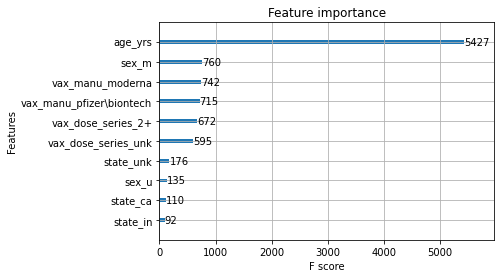

In [ ]:
baseline_boosting.fit(X1_train, y1_train)
plot_importance(baseline_boosting, max_num_features = 10)
pyplot.show()

* The most important feature, unsurprisingly, is age


# TF-IDF

In [ ]:
#incorporate both text and non-text features
features = ["vax_manu", "vax_dose_series", "state", "age_yrs", "sex", "lab_data_cleaned", "other_meds_cleaned", "cur_ill_cleaned", "history_cleaned", "prior_vax_cleaned", "allergies_cleaned"]
X = df[features] 
y = df["serious_se"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=3258)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 5829)

### Convert Categorical Vars to Dummy and Transform to Sparse Matrix

In [ ]:
X_train_sparse = sparse.csr_matrix(np.array(pd.get_dummies(X_train[features[:5]], drop_first = True)))
X_val_sparse = sparse.csr_matrix(np.array(pd.get_dummies(X_val[features[:5]], drop_first = True)))
X_test_sparse = sparse.csr_matrix(np.array(pd.get_dummies(X_test[features[:5]], drop_first = True)))

### Calculate TF-IDF for each text column

In [ ]:
#Lab Data
tv_lab_data = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_lab_data_train = tv_lab_data.fit_transform(X_train["lab_data_cleaned"].astype(str))
tv_lab_data_val = tv_lab_data.transform(X_val["lab_data_cleaned"].astype(str))
tv_lab_data_test = tv_lab_data.transform(X_test["lab_data_cleaned"].astype(str))
tv_lab_data_train.shape

(68866, 944)

In [ ]:
#Other Meds
tv_other_meds = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_other_meds_train = tv_other_meds.fit_transform(X_train["other_meds_cleaned"].astype(str))
tv_other_meds_val = tv_other_meds.transform(X_val["other_meds_cleaned"].astype(str))
tv_other_meds_test = tv_other_meds.transform(X_test["other_meds_cleaned"].astype(str))
tv_other_meds_train.shape

(68866, 815)

In [ ]:
#Current Illnesses
tv_cur_ill = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_cur_ill_train = tv_cur_ill.fit_transform(X_train["cur_ill_cleaned"].astype(str))
tv_cur_ill_val = tv_cur_ill.transform(X_val["cur_ill_cleaned"].astype(str))
tv_cur_ill_test = tv_cur_ill.transform(X_test["cur_ill_cleaned"].astype(str))
tv_cur_ill_train.shape

(68866, 171)

In [ ]:
#History 
tv_history = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_history_train = tv_history.fit_transform(X_train["history_cleaned"].astype(str))
tv_history_val = tv_history.transform(X_val["history_cleaned"].astype(str))
tv_history_test = tv_history.transform(X_test["history_cleaned"].astype(str))
tv_history_train.shape

(68866, 586)

In [ ]:
#Prior Vaccinations
tv_vax = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_vax_train = tv_vax.fit_transform(X_train["prior_vax_cleaned"].astype(str))
tv_vax_val = tv_vax.transform(X_val["prior_vax_cleaned"].astype(str))
tv_vax_test = tv_vax.transform(X_test["prior_vax_cleaned"].astype(str))
tv_vax_train.shape

(68866, 72)

In [ ]:
#Allergies
tv_allergies = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_allergies_train = tv_allergies.fit_transform(X_train["allergies_cleaned"].astype(str))
tv_allergies_val = tv_allergies.transform(X_val["allergies_cleaned"].astype(str))
tv_allergies_test = tv_allergies.transform(X_test["allergies_cleaned"].astype(str))
tv_allergies_train.shape

(68866, 212)

In [ ]:
scaler = StandardScaler()
#combine all text and non-text variables
xtrain = hstack((X_train_sparse, tv_lab_data_train, tv_other_meds_train, tv_cur_ill_train, tv_history_train, tv_vax_train, tv_allergies_train)).toarray()
xval = hstack((X_val_sparse, tv_lab_data_val, tv_other_meds_val, tv_cur_ill_val, tv_history_val, tv_vax_val, tv_allergies_val)).toarray()
xtest = hstack((X_test_sparse, tv_lab_data_test, tv_other_meds_test, tv_cur_ill_test, tv_history_test, tv_vax_test, tv_allergies_test)).toarray()
#standardize all variables
scaler.fit(xtrain)
xtrain = scaler.transform(xtrain)
xval = scaler.transform(xval)
xtest = scaler.transform(xtest)

In [ ]:
ytrain = np.array(y_train.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))
yval = np.array(y_val.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))
ytest = np.array(y_test.apply(lambda x: 0 if x == "not serious" else 
                                1 if x == "serious" else
                                2))

# Logistic Regression w/ Text

In [ ]:
lr_baseline = LogisticRegression(multi_class="multinomial", solver = "lbfgs")
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 3, random_state = 2352)
n_scores = cross_val_score(lr_baseline, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1)

In [ ]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.829 (0.001)


### Logistic Regression w/ L2 Penalty

In [ ]:
C = [0.0001, 0.0005, 0.001, 0.005, 0.01]
for c in C: 
    lr = LogisticRegression(multi_class="multinomial", solver = "lbfgs", penalty = "l2", C = c)
    lr_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
    n_scores = cross_val_score(lr, xtrain, ytrain, scoring = "accuracy", cv = lr_cv, n_jobs = -1)
    print("C:", c)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

C: 0.0001
Mean Accuracy: 0.843 (0.001)
C: 0.0005
Mean Accuracy: 0.842 (0.001)
C: 0.001
Mean Accuracy: 0.841 (0.001)
C: 0.005
Mean Accuracy: 0.837 (0.001)
C: 0.01
Mean Accuracy: 0.835 (0.001)


In [ ]:
#Accuracy decreases with increase in C, decrease C value
C = np.linspace(0, 0.00005, 3)
for c in C: 
    lr = LogisticRegression(multi_class="multinomial", solver = "lbfgs", penalty = "l2", C = c)
    lr_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
    n_scores = cross_val_score(lr, xtrain, ytrain, scoring = "accuracy", cv = lr_cv, n_jobs = -1)
    print("C:", c)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

C: 0.0
Mean Accuracy: 0.796 (0.000)
C: 2.5e-05
Mean Accuracy: 0.833 (0.000)
C: 5e-05
Mean Accuracy: 0.839 (0.001)


In [ ]:
lr = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", penalty = "l2", C = 0.0001)
lr.fit(xtrain, ytrain)
lr_predictions_proba = pd.DataFrame(lr.predict_proba(xval))
lr_preds = np.array(lr_predictions_proba.idxmax(axis = 1))

# Boosting w/ Text

### Maximizing Learning Rate and N Estimators

In [ ]:
acc = pd.DataFrame({"learning_rate": [], "n_estimators": [], "acc": []})
learning_rate = [0.05, 0.01, 0.001] #[0.5, 0.25, 0.1, 0.05]
n_estimators = [2000, 3000, 4000] #[100, 500, 1000]
for rate in learning_rate:
  for estimators in n_estimators:
    start = time.time()
    print(f"Rate: {rate}, N Estimators {estimators}")
    boost = XGBClassifier(learning_rate = rate, n_estimators= estimators, tree_method = "gpu_hist", random_state = 1530)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
    n_scores = cross_val_score(boost, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
    print(f"   Score: {np.round(np.mean(n_scores), 4)}")
    print(f"   Time Elapsed: {np.round(time.time() - start, 1)}")
    acc = pd.concat([acc, pd.DataFrame({"learning_rate": [rate], "n_estimators": [estimators], "acc": [np.mean(n_scores)]})], axis = 0)

Rate: 0.05, N Estimators 2000
   Score: 0.8503
   Time Elapsed: 298.2
Rate: 0.05, N Estimators 3000
   Score: 0.8498
   Time Elapsed: 453.4
Rate: 0.05, N Estimators 4000
   Score: 0.8498
   Time Elapsed: 579.6
Rate: 0.01, N Estimators 2000
   Score: 0.8461
   Time Elapsed: 310.8
Rate: 0.01, N Estimators 3000
   Score: 0.8471
   Time Elapsed: 455.2
Rate: 0.01, N Estimators 4000
   Score: 0.848
   Time Elapsed: 597.9
Rate: 0.001, N Estimators 2000
   Score: 0.8287
   Time Elapsed: 333.0
Rate: 0.001, N Estimators 3000
   Score: 0.832
   Time Elapsed: 522.5
Rate: 0.001, N Estimators 4000
   Score: 0.8342
   Time Elapsed: 680.9


### Maximize max depth of tree and L2 regularization

In [ ]:
acc2 = pd.DataFrame({"depth": [], "lambda": [], "acc": []})
depths = [5, 6, 7] #[6, 8, 10]
lambdas = [0.25, 0.1, 0.01] #[0.01, 0.001, 0.0001]
for depth in depths:
  for lambda_ in lambdas:
    start = time.time()
    print(f"Depth: {depth}, Lambda {lambda_}")
    boost = XGBClassifier(learning_rate = 0.05, n_estimators= 2000, max_depth = depth, reg_lambda = lambda_, tree_method = "gpu_hist", random_state = 1530)
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
    n_scores = cross_val_score(boost, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")
    print(f"   Score: {np.round(np.mean(n_scores), 4)}")
    print(f"   Time Elapsed: {np.round(time.time() - start, 1)}")
    acc2 = pd.concat([acc, pd.DataFrame({"depth": [depth], "lambda": [lambda_], "acc": [np.mean(n_scores)]})], axis = 0)

Depth: 5, Lambda 0.25
   Score: 0.8511
   Time Elapsed: 368.4
Depth: 5, Lambda 0.1
   Score: 0.8511
   Time Elapsed: 370.8
Depth: 5, Lambda 0.01
   Score: 0.851
   Time Elapsed: 377.7
Depth: 6, Lambda 0.25
   Score: 0.8509
   Time Elapsed: 427.9
Depth: 6, Lambda 0.1
   Score: 0.851
   Time Elapsed: 422.3
Depth: 6, Lambda 0.01
   Score: 0.8507
   Time Elapsed: 423.8
Depth: 7, Lambda 0.25
   Score: 0.8514
   Time Elapsed: 468.8
Depth: 7, Lambda 0.1
   Score: 0.8506
   Time Elapsed: 474.3
Depth: 7, Lambda 0.01
   Score: 0.8505
   Time Elapsed: 478.8


In [ ]:
boosting = XGBClassifier(learning_rate = 0.05, n_estimators= 2000, max_depth = 7, reg_lambda = 0.25, tree_method = "gpu_hist", random_state = 1530)
boosting.fit(xtrain, ytrain)
boosting_predictions_proba = pd.DataFrame(boosting.predict_proba(xval))
boosting_preds = np.array(boosting_predictions_proba.idxmax(axis = 1))

# SVM w/ Text

In [ ]:
baseline_svm = LinearSVC(random_state = 2320)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=2352)
n_scores = cross_val_score(baseline_svm, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")

In [ ]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.817 (0.001)


In [ ]:
C = [0.0001, 0.0005, 0.001, 0.005, 0.01]
for c in C: 
    svm = LinearSVC(random_state = 2320, penalty = "l2", C = c)
    svm_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
    n_scores = cross_val_score(svm, xtrain, ytrain, scoring = "accuracy", cv = svm_cv, n_jobs = -1)
    print("C:", c)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

C: 0.0001
Mean Accuracy: 0.844 (0.001)
C: 0.0005
Mean Accuracy: 0.842 (0.001)
C: 0.001
Mean Accuracy: 0.841 (0.001)
C: 0.005
Mean Accuracy: 0.839 (0.001)


/Users/jordanfan/opt/anaconda3/envs/vaers/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


C: 0.01
Mean Accuracy: 0.838 (0.001)


In [ ]:
C = np.linspace(0, 0.00005, 3)
for c in C: 
    svm = LinearSVC(random_state = 2320, penalty = "l2", C = c)
    svm_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
    n_scores = cross_val_score(svm, xtrain, ytrain, scoring = "accuracy", cv = svm_cv, n_jobs = -1)
    print("C:", c)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

C: 0.0
Mean Accuracy: nan (nan)
C: 2.5e-05
Mean Accuracy: 0.844 (0.001)
C: 5e-05
Mean Accuracy: 0.845 (0.001)


In [ ]:
svm = LinearSVC(random_state = 2320, penalty = "l2", C = 0.00005)
svm.fit(xtrain, ytrain)
svm_conf_scores = pd.DataFrame(svm.decision_function(xval))
svm_preds = svm.predict(xval)

# KNN w/ Text

In [ ]:
baseline_knn = KNeighborsClassifier()
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
n_scores = cross_val_score(baseline_knn, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")

In [ ]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.801 (0.002)


In [ ]:
# standard number of neighbors is sqrt(# Rows)/2
knn2 = KNeighborsClassifier(algorithm = "ball_tree", n_neighbors = int((xtrain.shape[0])**(1/2)//2))
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
n_scores = cross_val_score(knn2, xtrain, ytrain, scoring = "accuracy", cv = cv, n_jobs = -1, error_score = "raise")

In [ ]:
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Mean Accuracy: 0.796 (0.000)


Result is worse than baseline, just use baseline

In [ ]:

knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
knn_predictions_proba = pd.DataFrame(knn.predict_proba(xval))
knn_preds = np.array(knn_predictions_proba.idxmax(axis = 1))

# Neural Network w/ Text

In [ ]:
#further split training to use as validation
n = xtrain.shape[0]*4//5
x_train = xtrain[:n]
x_val = xtrain[n:]
y_train = to_categorical(ytrain[:n])
y_val = to_categorical(ytrain[n:])
y_test = to_categorical(yval)

In [ ]:
baseline_nn = Sequential()
baseline_nn.add(Dense(64, activation = "relu", input_shape = (x_train.shape[1],)))
baseline_nn.add(Dense(32, activation = "relu"))
baseline_nn.add(Dense(3, activation='softmax'))
baseline_nn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = baseline_nn.fit(x_train,
          y_train,
          epochs=10,
          batch_size=64,
          validation_data=(x_val, y_val))

Epoch 1/10
861/861 [==============================] - 16s 14ms/step - loss: 0.5780 - accuracy: 0.8023 - val_loss: 0.4671 - val_accuracy: 0.8348
Epoch 2/10
861/861 [==============================] - 9s 11ms/step - loss: 0.4086 - accuracy: 0.8557 - val_loss: 0.4715 - val_accuracy: 0.8385
Epoch 3/10
861/861 [==============================] - 11s 13ms/step - loss: 0.3747 - accuracy: 0.8677 - val_loss: 0.4707 - val_accuracy: 0.8377
Epoch 4/10
861/861 [==============================] - 10s 11ms/step - loss: 0.3510 - accuracy: 0.8783 - val_loss: 0.4813 - val_accuracy: 0.8364
Epoch 5/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3298 - accuracy: 0.8881 - val_loss: 0.5105 - val_accuracy: 0.8359
Epoch 6/10
861/861 [==============================] - 10s 11ms/step - loss: 0.3084 - accuracy: 0.8968 - val_loss: 0.5370 - val_accuracy: 0.8276
Epoch 7/10
861/861 [==============================] - 10s 11ms/step - loss: 0.2928 - accuracy: 0.9031 - val_loss: 0.5871 - val_accuracy: 

### Increase number of nodes

In [ ]:
nn2 = Sequential()
nn2.add(Dense(128, activation = "relu", input_shape = (x_train.shape[1],)))
nn2.add(Dense(64, activation = "relu"))
nn2.add(Dense(3, activation='softmax'))
nn2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = nn2.fit(x_train,
          y_train,
          epochs=10,
          batch_size=64,
          validation_data=(x_val, y_val))

Epoch 1/10
861/861 [==============================] - 13s 11ms/step - loss: 0.5290 - accuracy: 0.8149 - val_loss: 0.4513 - val_accuracy: 0.8408
Epoch 2/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3996 - accuracy: 0.8599 - val_loss: 0.4583 - val_accuracy: 0.8389
Epoch 3/10
861/861 [==============================] - 9s 11ms/step - loss: 0.3643 - accuracy: 0.8742 - val_loss: 0.4811 - val_accuracy: 0.8382
Epoch 4/10
861/861 [==============================] - 9s 10ms/step - loss: 0.3380 - accuracy: 0.8850 - val_loss: 0.5059 - val_accuracy: 0.8343
Epoch 5/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3070 - accuracy: 0.8978 - val_loss: 0.5442 - val_accuracy: 0.8306
Epoch 6/10
861/861 [==============================] - 10s 12ms/step - loss: 0.2902 - accuracy: 0.9027 - val_loss: 0.5901 - val_accuracy: 0.8219
Epoch 7/10
861/861 [==============================] - 9s 11ms/step - loss: 0.2666 - accuracy: 0.9128 - val_loss: 0.6454 - val_accuracy: 0.

### Add additional layer

In [ ]:
nn3 = Sequential()
nn3.add(Dense(128, activation = "relu", input_shape = (x_train.shape[1],)))
nn3.add(Dense(64, activation = "relu"))
nn3.add(Dense(32, activation = "relu"))
nn3.add(Dense(3, activation='softmax'))
nn3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = nn3.fit(x_train,
          y_train,
          epochs=10,
          batch_size=64,
          validation_data=(x_val, y_val))

Epoch 1/10
861/861 [==============================] - 14s 14ms/step - loss: 0.5058 - accuracy: 0.8242 - val_loss: 0.4508 - val_accuracy: 0.8388
Epoch 2/10
861/861 [==============================] - 10s 12ms/step - loss: 0.4175 - accuracy: 0.8528 - val_loss: 0.4583 - val_accuracy: 0.8369
Epoch 3/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3831 - accuracy: 0.8671 - val_loss: 0.4588 - val_accuracy: 0.8411
Epoch 4/10
861/861 [==============================] - 11s 12ms/step - loss: 0.3589 - accuracy: 0.8741 - val_loss: 0.4916 - val_accuracy: 0.8425
Epoch 5/10
861/861 [==============================] - 10s 12ms/step - loss: 0.3388 - accuracy: 0.8834 - val_loss: 0.5069 - val_accuracy: 0.8359
Epoch 6/10
861/861 [==============================] - 9s 11ms/step - loss: 0.3151 - accuracy: 0.8930 - val_loss: 0.5475 - val_accuracy: 0.8367
Epoch 7/10
861/861 [==============================] - 10s 12ms/step - loss: 0.2917 - accuracy: 0.9024 - val_loss: 0.5732 - val_accuracy: 

### Add Dropout

In [ ]:
nn4 = Sequential()
nn4.add(Dense(128, activation = "relu", input_shape = (x_train.shape[1],)))
nn4.add(Dropout(0.2))
nn4.add(Dense(64, activation = "relu"))
nn4.add(Dropout(0.2))
nn4.add(Dense(32, activation = "relu"))
nn4.add(Dense(3, activation='softmax'))
nn4.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = nn4.fit(x_train,
          y_train,
          epochs=10,
          batch_size=64,
          validation_data=(x_val, y_val))

Epoch 1/10
861/861 [==============================] - 15s 11ms/step - loss: 0.5575 - accuracy: 0.8051 - val_loss: 0.4477 - val_accuracy: 0.8388
Epoch 2/10
861/861 [==============================] - 9s 10ms/step - loss: 0.4541 - accuracy: 0.8429 - val_loss: 0.4407 - val_accuracy: 0.8417
Epoch 3/10
861/861 [==============================] - 9s 11ms/step - loss: 0.4311 - accuracy: 0.8508 - val_loss: 0.4470 - val_accuracy: 0.8428
Epoch 4/10
861/861 [==============================] - 9s 11ms/step - loss: 0.4179 - accuracy: 0.8571 - val_loss: 0.4439 - val_accuracy: 0.8403
Epoch 5/10
861/861 [==============================] - 10s 12ms/step - loss: 0.4085 - accuracy: 0.8574 - val_loss: 0.4413 - val_accuracy: 0.8461
Epoch 6/10
861/861 [==============================] - 9s 11ms/step - loss: 0.4062 - accuracy: 0.8597 - val_loss: 0.4466 - val_accuracy: 0.8441
Epoch 7/10
861/861 [==============================] - 10s 11ms/step - loss: 0.3950 - accuracy: 0.8663 - val_loss: 0.4457 - val_accuracy: 0.8

In [ ]:
nn = Sequential()
nn.add(Dense(256, activation = "relu", input_shape = (x_train.shape[1],))) 
nn.add(Dropout(0.5))
nn.add(Dense(128, activation='relu'))
nn.add(Dropout(0.5))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(3, activation='softmax'))
nn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) 
history = nn.fit(x_train,
          y_train,
          epochs=10,
          batch_size=128,
          validation_data=(x_val, y_val))

Epoch 1/10
431/431 [==============================] - 15s 27ms/step - loss: 0.6404 - accuracy: 0.7843 - val_loss: 0.4619 - val_accuracy: 0.8343
Epoch 2/10
431/431 [==============================] - 10s 24ms/step - loss: 0.4756 - accuracy: 0.8383 - val_loss: 0.4559 - val_accuracy: 0.8351
Epoch 3/10
431/431 [==============================] - 11s 25ms/step - loss: 0.4599 - accuracy: 0.8413 - val_loss: 0.4495 - val_accuracy: 0.8383
Epoch 4/10
431/431 [==============================] - 12s 27ms/step - loss: 0.4460 - accuracy: 0.8487 - val_loss: 0.4437 - val_accuracy: 0.8395
Epoch 5/10
431/431 [==============================] - 11s 25ms/step - loss: 0.4439 - accuracy: 0.8465 - val_loss: 0.4524 - val_accuracy: 0.8334
Epoch 6/10
431/431 [==============================] - 11s 25ms/step - loss: 0.4264 - accuracy: 0.8534 - val_loss: 0.4502 - val_accuracy: 0.8319
Epoch 7/10
431/431 [==============================] - 11s 25ms/step - loss: 0.4255 - accuracy: 0.8537 - val_loss: 0.4432 - val_accuracy:

In [ ]:
nn_predictions_proba = pd.DataFrame(nn.predict(xval))
nn_preds = np.array(nn_predictions_proba.idxmax(axis = 1))

# Compare Results

In [ ]:
print(classification_report(yval, lr_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.857     0.980     0.915     13702
           1      0.760     0.372     0.499      3006
           2      0.671     0.104     0.180       509

    accuracy                          0.848     17217
   macro avg      0.763     0.485     0.531     17217
weighted avg      0.835     0.848     0.821     17217



In [ ]:
print(classification_report(yval, boosting_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.872     0.974     0.920     13702
           1      0.746     0.402     0.522      3006
           2      0.580     0.328     0.419       509

    accuracy                          0.855     17217
   macro avg      0.732     0.568     0.620     17217
weighted avg      0.841     0.855     0.836     17217



In [ ]:
print(classification_report(yval, svm_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.865     0.972     0.916     13702
           1      0.728     0.412     0.526      3006
           2      0.590     0.136     0.220       509

    accuracy                          0.850     17217
   macro avg      0.728     0.506     0.554     17217
weighted avg      0.833     0.850     0.827     17217



In [ ]:
print(classification_report(yval, knn_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.822     0.970     0.890     13702
           1      0.520     0.166     0.251      3006
           2      0.541     0.104     0.175       509

    accuracy                          0.804     17217
   macro avg      0.628     0.413     0.439     17217
weighted avg      0.761     0.804     0.757     17217



In [ ]:
print(classification_report(yval, nn_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.863     0.972     0.914     13702
           1      0.744     0.382     0.505      3006
           2      0.466     0.230     0.308       509

    accuracy                          0.847     17217
   macro avg      0.691     0.528     0.576     17217
weighted avg      0.831     0.847     0.825     17217



logistic regression, boosting, and SVM are top models. Use the models to blend

## Blend Models

In [ ]:
# combine prediction probabilities of each model for training and test
blended_x = np.array(pd.concat([lr_predictions_proba, boosting_predictions_proba, svm_conf_scores], axis = 1))
lr_test_proba = pd.DataFrame(lr.predict_proba(xtest))
boosting_test_proba = pd.DataFrame(boosting.predict_proba(xtest))
svm_test_conf_score = pd.DataFrame(svm.decision_function(xtest))
blended_x_test = np.array(pd.concat([lr_test_proba, boosting_test_proba, svm_test_conf_score], axis = 1))


In [ ]:

blender = LogisticRegression(multi_class="multinomial")
blender.fit(blended_x, yval)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(classification_report(ytest, blender.predict(blended_x_test), digits = 3))

              precision    recall  f1-score   support

           0      0.874     0.973     0.921     17158
           1      0.728     0.413     0.527      3658
           2      0.583     0.295     0.392       705

    accuracy                          0.856     21521
   macro avg      0.728     0.560     0.613     21521
weighted avg      0.840     0.856     0.837     21521



test predictions are pretty low with improvement of <6% from baseline

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/blended_test_preds.pkl", "wb") as handle:
  pickle.dump(blender.predict(blended_x_test), handle)

# Important Words

In [ ]:
# Combine only text features into a matrix
Xtr = hstack((tv_lab_data_train, tv_other_meds_train, tv_cur_ill_train, tv_history_train, tv_vax_train, tv_allergies_train))

# Combine all text names into a list to lookup by index
tfidf_features = ["lab_data_" + i for i in tv_lab_data.get_feature_names()] \
+ ["other_meds_" + i for i in tv_other_meds.get_feature_names()] \
+ ["cur_ill_" + i for i in tv_cur_ill.get_feature_names()] \
+ ["history_" + i for i in tv_history.get_feature_names()] \
+ ["vax_" + i for i in tv_vax.get_feature_names()] \
+ ["allergies_" + i for i in tv_allergies.get_feature_names()] 


def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(tfidf_features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr.toarray()[row_id])
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids is not None:
        D = Xtr.toarray()[grp_ids]
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)[0]
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [ ]:
top_feats_in_doc(Xtr, tfidf_features, 1, top_n = 10)

,feature,tfidf
0,allergies_nkda,1.000000
1,cur_ill_nan,1.000000
2,vax_nan,1.000000
3,history_statu,0.615232
4,history_post,0.537443
5,lab_data_mild,0.314362
6,other_meds_mouth daili,0.308630
7,lab_data_three,0.306009
8,other_meds_take,0.305228
9,other_meds_tablet take,0.301120


In [ ]:
top_mean_feats(Xtr, tfidf_features)

,feature,tfidf
0,vax_nan,0.951979
1,lab_data_nan,0.583713
2,cur_ill_nan,0.494598
3,allergies_nan,0.412424
4,other_meds_nan,0.377138
5,cur_ill_none,0.343041
6,history_nan,0.296678
7,allergies_none,0.189491
8,history_none,0.180278
9,lab_data_none,0.176411


In [ ]:
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

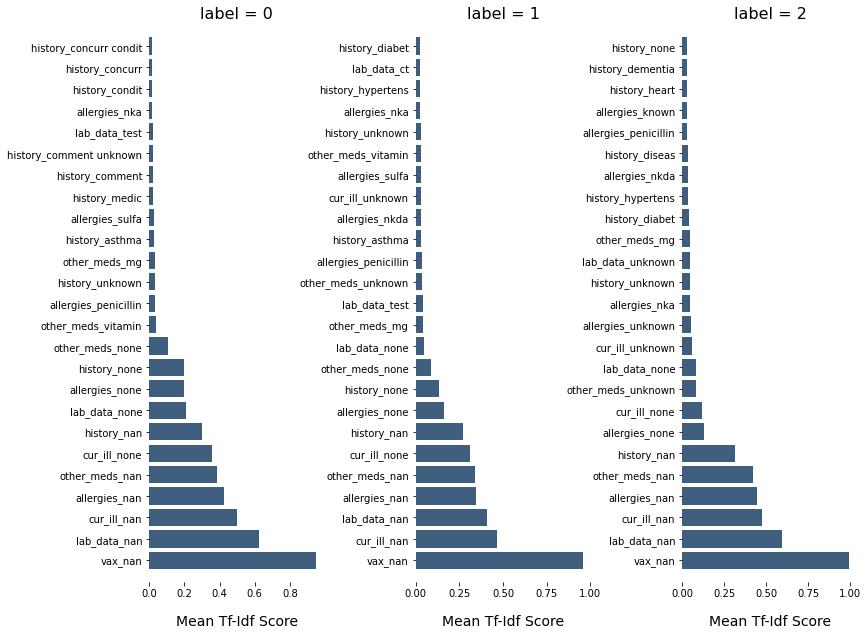

In [ ]:
plot_tfidf_classfeats_h(top_feats_by_class(Xtr, ytrain, features))

### Important features from Boosting

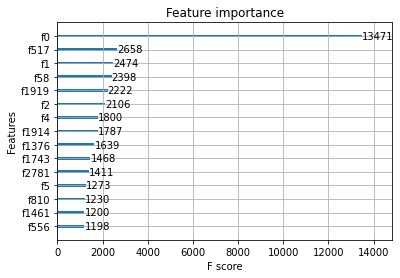

In [ ]:
plot_importance(boosting, max_num_features = 15)
pyplot.show()

In [ ]:
feature_names = list(pd.get_dummies(X_train[features[:5]], drop_first = True).columns) \
+ ["lab_data_" + i for i in tv_lab_data.get_feature_names()] \
+ ["other_meds_" + i for i in tv_other_meds.get_feature_names()] \
+ ["cur_ill_" + i for i in tv_cur_ill.get_feature_names()] \
+ ["history_" + i for i in tv_history.get_feature_names()] \
+ ["vax_" + i for i in tv_vax.get_feature_names()] \
+ ["allergies_" + i for i in tv_allergies.get_feature_names()] 
[feature_names[i] for i in [0, 517, 1, 58, 1919, 2, 4, 1914, 1376, 1743, 2781, 5, 810, 1461, 556]]

['age_yrs',
 'lab_data_nan',
 'vax_manu_moderna',
 'sex_m',
 'cur_ill_none',
 'vax_manu_pfizer\\biontech',
 'vax_dose_series_2+',
 'cur_ill_nan',
 'other_meds_mg',
 'other_meds_vitamin',
 'allergies_none',
 'vax_dose_series_unk',
 'lab_data_test',
 'other_meds_nan',
 'lab_data_none']

# Incorporate Active Ingredients

In [ ]:
df2 = pd.read_csv("../../src/processed/covid_vaccine_symptoms 2.csv")
df2["active_ingredients"] = df2["active_ingredients"].apply(lambda x: ", ".join(i for i in eval(x)))
df2["drug_group"] = df2["drug_group"].apply(lambda x: ", ".join(i for i in eval(x)))

In [ ]:
features2 = ["vax_manu", "vax_dose_series", "state", "age_yrs", "sex", "lab_data_cleaned", "other_meds_cleaned", "cur_ill_cleaned", "history_cleaned", "prior_vax_cleaned", "allergies_cleaned", "active_ingredients_cleaned", "drug_group_cleaned"]
X2 = df2[features2] 
y2 = df2["serious_se"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.2, random_state=3258)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size = 0.2, random_state = 5829)

In [ ]:
#Active Ingredient
tv_ai = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_ai_train = tv_ai.fit_transform(X2_train["active_ingredients_cleaned"].astype(str))
tv_ai_val = tv_ai.transform(X2_val["active_ingredients_cleaned"].astype(str))
tv_ai_test = tv_ai.transform(X2_test["active_ingredients_cleaned"].astype(str))
tv_ai_train.shape

(68866, 475)

In [ ]:
#Drug Group
tv_dg = TfidfVectorizer(min_df = 0.001, ngram_range = (1,3))
tv_dg_train = tv_dg.fit_transform(X2_train["drug_group_cleaned"].astype(str))
tv_dg_val = tv_dg.transform(X2_val["drug_group_cleaned"].astype(str))
tv_dg_test = tv_dg.transform(X2_test["drug_group_cleaned"].astype(str))
tv_dg_train.shape

(68866, 291)

In [ ]:
scaler2 = StandardScaler()
xtrain2 = hstack((X_train_sparse, tv_lab_data_train, tv_other_meds_train, tv_cur_ill_train, tv_history_train, tv_vax_train, tv_allergies_train, tv_ai_train, tv_dg_train)).toarray()
xval2 = hstack((X_val_sparse, tv_lab_data_val, tv_other_meds_val, tv_cur_ill_val, tv_history_val, tv_vax_val, tv_allergies_val, tv_ai_val, tv_dg_val)).toarray()
xtest2 = hstack((X_test_sparse, tv_lab_data_test, tv_other_meds_test, tv_cur_ill_test, tv_history_test, tv_vax_test, tv_allergies_test, tv_ai_test, tv_dg_test)).toarray()
scaler2.fit(xtrain2)
xtrain2 = scaler2.transform(xtrain2)
xval2 = scaler2.transform(xval2)
xtest2 = scaler2.transform(xtest2)

## Logistic Regression

In [ ]:
C = [0, 0.000025, 0.00005, 0.0001]
for c in C: 
    lr = LogisticRegression(multi_class="multinomial", solver = "lbfgs", penalty = "l2", C = c)
    lr_cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2352)
    n_scores = cross_val_score(lr, xtrain2, ytrain, scoring = "accuracy", cv = lr_cv, n_jobs = -1)
    print("C:", c)
    print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

C: 0
Mean Accuracy: nan (nan)
C: 2.5e-05
Mean Accuracy: 0.834 (0.001)
C: 5e-05
Mean Accuracy: 0.839 (0.001)
C: 0.0001
Mean Accuracy: 0.842 (0.001)


In [ ]:
lr2 = LogisticRegression(multi_class = "multinomial", solver = "lbfgs", penalty = "l2", C = 0.0001)
lr2.fit(xtrain2, ytrain)
lr2_predictions_proba = pd.DataFrame(lr2.predict_proba(xval2))
lr2_preds = np.array(lr2_predictions_proba.idxmax(axis = 1))

## Boosting

In [ ]:
boosting_clf_lr2 = HistGradientBoostingClassifier(random_state = 1530, tol = 0.00001)
cv = 3
params = {"learning_rate": [0.2, 0.15, 0.1, 0.05, 0.5],
          }
model = GridSearchCV(boosting_clf_lr2, 
                     param_grid = params, 
                     scoring = "f1_weighted", 
                     n_jobs = -1, 
                     cv = cv, 
                    verbose = 3)
model.fit(xtrain2, ytrain)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .................learning_rate=0.2;, score=0.827 total time=10.4min
[CV 3/3] END ................learning_rate=0.15;, score=0.829 total time= 7.3min
[CV 1/3] END ................learning_rate=0.05;, score=0.827 total time=20.1min
[CV 2/3] END .................learning_rate=0.2;, score=0.833 total time= 9.5min
[CV 2/3] END ................learning_rate=0.15;, score=0.833 total time= 7.2min
[CV 3/3] END .................learning_rate=0.1;, score=0.828 total time=14.0min
[CV 1/3] END .................learning_rate=0.5;, score=0.813 total time= 2.9min
[CV 2/3] END .................learning_rate=0.5;, score=0.817 total time= 2.8min
[CV 3/3] END .................learning_rate=0.5;, score=0.816 total time= 3.9min


GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(random_state=1530,
                                                      tol=1e-05),
             n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.15, 0.1, 0.05, 0.5]},
             scoring='f1_weighted', verbose=3)

[CV 3/3] END .................learning_rate=0.2;, score=0.827 total time=11.4min
[CV 1/3] END .................learning_rate=0.1;, score=0.826 total time=10.6min
[CV 2/3] END ................learning_rate=0.05;, score=0.833 total time=19.9min
[CV 1/3] END ................learning_rate=0.15;, score=0.827 total time=11.5min
[CV 2/3] END .................learning_rate=0.1;, score=0.833 total time=10.9min
[CV 3/3] END ................learning_rate=0.05;, score=0.829 total time=19.7min


In [ ]:
model.best_params_

{'learning_rate': 0.15}

In [ ]:
boosting_clf_l2 = HistGradientBoostingClassifier(learning_rate = 0.15, random_state = 1530, tol = 0.00001)
cv = 3
params = {"l2_regularization": [0, 0.0001, 0.001, 0.01],
          }
model = GridSearchCV(boosting_clf_l2, 
                     param_grid = params, 
                     scoring = "f1_weighted", 
                     n_jobs = -1, 
                     cv = cv, 
                    verbose = 3)
model.fit(xtrain2, ytrain)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


GridSearchCV(cv=3,
             estimator=HistGradientBoostingClassifier(learning_rate=0.15,
                                                      random_state=1530,
                                                      tol=1e-05),
             n_jobs=-1,
             param_grid={'l2_regularization': [0, 0.0001, 0.001, 0.01]},
             scoring='f1_weighted', verbose=3)

[CV 1/3] END ...............l2_regularization=0;, score=0.827 total time= 9.7min
[CV 2/3] END ..........l2_regularization=0.0001;, score=0.833 total time= 5.3min
[CV 3/3] END ...........l2_regularization=0.001;, score=0.829 total time= 6.8min
[CV 1/3] END ..........l2_regularization=0.0001;, score=0.827 total time=10.3min
[CV 1/3] END ...........l2_regularization=0.001;, score=0.827 total time= 5.7min
[CV 1/3] END ............l2_regularization=0.01;, score=0.825 total time= 5.7min
[CV 2/3] END ...............l2_regularization=0;, score=0.833 total time=10.2min
[CV 3/3] END ..........l2_regularization=0.0001;, score=0.829 total time= 6.5min
[CV 2/3] END ............l2_regularization=0.01;, score=0.834 total time= 5.3min
[CV 3/3] END ...............l2_regularization=0;, score=0.829 total time=11.5min
[CV 2/3] END ...........l2_regularization=0.001;, score=0.833 total time= 6.0min
[CV 3/3] END ............l2_regularization=0.01;, score=0.829 total time= 5.9min


In [ ]:
model.best_params_

{'l2_regularization': 0}

In [ ]:
boosting2 = HistGradientBoostingClassifier(learning_rate = 0.15, random_state = 1530, tol = 0.00001, l2_regularization = 0.001)
boosting2.fit(xtrain2, ytrain)
boosting2_predictions_proba = pd.DataFrame(boosting.predict_proba(xval))
boosting2_preds = np.array(boosting_predictions_proba.idxmax(axis = 1))

In [ ]:
print(classification_report(yval, boosting2_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.872     0.974     0.920     13702
           1      0.746     0.402     0.522      3006
           2      0.580     0.328     0.419       509

    accuracy                          0.855     17217
   macro avg      0.732     0.568     0.620     17217
weighted avg      0.841     0.855     0.836     17217



* Not adding any significant improvement on boosting training, cease maximizing rest of models